<table align="center">
  <td align="center"><a target="_blank" href="http://introtodeeplearning.com">
        <img src="https://i.ibb.co/Jr88sn2/mit.png" style="padding-bottom:5px;" />
      Visit MIT Deep Learning</a></td>
  <td align="center"><a target="_blank" href="https://colab.research.google.com/github/aamini/introtodeeplearning/blob/master/lab3/RL.ipynb">
        <img src="https://i.ibb.co/2P3SLwK/colab.png"  style="padding-bottom:5px;" />Run in Google Colab</a></td>
  <td align="center"><a target="_blank" href="https://github.com/aamini/introtodeeplearning/blob/master/lab3/RL.ipynb">
        <img src="https://i.ibb.co/xfJbPmL/github.png"  height="70px" style="padding-bottom:5px;"  />View Source on GitHub</a></td>
</table>

# Copyright Information

In [1]:
# Copyright 2022 MIT 6.S191 Introduction to Deep Learning. All Rights Reserved.
#
# Licensed under the MIT License. You may not use this file except in compliance
# with the License. Use and/or modification of this code outside of 6.S191 must
# reference:
#
# © MIT 6.S191: Introduction to Deep Learning
# http://introtodeeplearning.com
#

# Laboratory 3: Reinforcement Learning

Reinforcement learning (RL) is a subset of machine learning which poses learning problems as interactions between agents and environments. It often assumes agents have no prior knowledge of a world, so they must learn to navigate environments by optimizing a reward function. Within an environment, an agent can take certain actions and receive feedback, in the form of positive or negative rewards, with respect to their decision. As such, an agent's feedback loop is somewhat akin to the idea of "trial and error", or the manner in which a child might learn to distinguish between "good" and "bad" actions.

In practical terms, our RL agent will interact with the environment by taking an action at each timestep, receiving a corresponding reward, and updating its state according to what it has "learned".  

![alt text](https://www.kdnuggets.com/images/reinforcement-learning-fig1-700.jpg)

While the ultimate goal of reinforcement learning is to teach agents to act in the real, physical world, simulated environments -- like games and simulation engines -- provide a convenient proving ground for developing RL algorithms and agents.

In previous labs, we have explored both supervised (with LSTMs, CNNs) and unsupervised / semi-supervised (with VAEs) learning tasks. Reinforcement learning is fundamentally different, in that we are training a deep learning algorithm to govern the actions of our RL agent, that is trying, within its environment, to find the optimal way to achieve a goal. The goal of training an RL agent is to determine the best next step to take to earn the greatest final payoff or return. In this lab, we focus on building a reinforcement learning algorithm to master two different environments with varying complexity.

1.   **Cartpole**:   Balance a pole, protruding from a cart, in an upright position by only moving the base left or right. Environment with a low-dimensional observation space.
2.   [**Driving in VISTA**](https://www.mit.edu/~amini/pubs/pdf/learning-in-simulation-vista.pdf): Learn a driving control policy for an autonomous vehicle, end-to-end from raw pixel inputs and entirely in the data-driven simulation environment of VISTA. Environment with a high-dimensional observation space -- learning directly from raw pixels.

Let's get started! First we'll import TensorFlow, the course package, and some dependencies.


## Package Imports

In [2]:
# Import Tensorflow 2.0
#%tensorflow_version 2.x
import tensorflow.compat.v2 as tf
import tensorflow_probability as tfp

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)

# Download and import the MIT 6.S191 package
!printf "Installing MIT deep learning package... "
!pip install --upgrade git+https://github.com/aamini/introtodeeplearning.git &> /dev/null
!echo "Done"

Installing MIT deep learning package... Done


In [4]:
#Install some dependencies for visualizing the agents
!apt-get install -y xvfb python-opengl x11-utils &> /dev/null
!pip install gym pyvirtualdisplay scikit-video ffio pyrender &> /dev/null
!pip install tensorflow_probability==0.12.0 &> /dev/null
import os
os.environ['PYOPENGL_PLATFORM'] = 'egl'

import numpy as np
import matplotlib, cv2
import matplotlib.pyplot as plt
import base64, io, os, time, gym
import IPython, functools
import time
from tqdm import tqdm


import mitdeeplearning as mdl

Before we dive in, let's take a step back and outline our approach, which is generally applicable to reinforcement learning problems in general:

1. **Initialize our environment and our agent**: here we will describe the different observations and actions the agent can make in the environemnt.
2. **Define our agent's memory**: this will enable the agent to remember its past actions, observations, and rewards.
3. **Define a reward function**: describes the reward associated with an action or sequence of actions.
4. **Define the learning algorithm**: this will be used to reinforce the agent's good behaviors and discourage bad behaviors.


# Part 1: Cartpole

## 3.1 Define the Cartpole environment and agent

### Environment

In order to model the environment for the Cartpole task, we'll be using a toolkit developed by OpenAI called [OpenAI Gym](https://gym.openai.com/). It provides several pre-defined environments for training and testing reinforcement learning agents, including those for classic physics control tasks, Atari video games, and robotic simulations. To access the Cartpole environment, we can use `env = gym.make("CartPole-v0")`, which we gained access to when we imported the `gym` package. We can instantiate different [environments](https://gym.openai.com/envs/#classic_control) by passing the enivronment name to the `make` function.

One issue we might experience when developing RL algorithms is that many aspects of the learning process are inherently random: initializing game states, changes in the environment, and the agent's actions. As such, it can be helpful to set a initial "seed" for the environment to ensure some level of reproducibility. Much like you might use `numpy.random.seed`, we can call the comparable function in gym, `seed`, with our defined environment to ensure the environment's random variables are initialized the same each time.

In [5]:
### Instantiate the Cartpole environment ###

env = gym.make("CartPole-v1")
env.seed(1)

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(


[1]

In Cartpole, a pole is attached by an un-actuated joint to a cart, which moves along a frictionless track. The pole starts upright, and the goal is to prevent it from falling over. The system is controlled by applying a force of +1 or -1 to the cart. A reward of +1 is provided for every timestep that the pole remains upright. The episode ends when the pole is more than 15 degrees from vertical, or the cart moves more than 2.4 units from the center of the track. A visual summary of the cartpole environment is depicted below:

<img width="400px" src="https://danielpiedrahita.files.wordpress.com/2017/02/cart-pole.png"></img>

Given this setup for the environment and the objective of the game, we can think about: 1) what observations help define the environment's state; 2) what actions the agent can take.

First, let's consider the observation space. In this Cartpole environment our observations are:

1. Cart position
2. Cart velocity
3. Pole angle
4. Pole rotation rate

We can confirm the size of the space by querying the environment's observation space:


In [6]:
n_observations = env.observation_space
print("Environment has observation space =", n_observations)

Environment has observation space = Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)


Second, we consider the action space. At every time step, the agent can move either right or left. Again we can confirm the size of the action space by querying the environment:

In [7]:
n_actions = env.action_space.n
print("Number of possible actions that the agent can choose from =", n_actions)

Number of possible actions that the agent can choose from = 2


### Cartpole agent

Now that we have instantiated the environment and understood the dimensionality of the observation and action spaces, we are ready to define our agent. In deep reinforcement learning, a deep neural network defines the agent. This network will take as input an observation of the environment and output the probability of taking each of the possible actions. Since Cartpole is defined by a low-dimensional observation space, a simple feed-forward neural network should work well for our agent. We will define this using the `Sequential` API.


#### `def create_cartpole_model()`

In [8]:
### Define the Cartpole agent ###

# Defines a feed-forward neural network
def create_cartpole_model():
    model = tf.keras.models.Sequential([
        # First Dense layer
        tf.keras.layers.Dense(units=32, activation='relu'),

        # TODO: Define the last Dense layer, which will provide the network's output.
        # Think about the space the agent needs to act in!
        # ['''TODO''' Dense layer to output action probabilities]
        #n_actions = 2, but instead of hardcoding it, leave it tied to the variable for future use
        #tf.keras.layers.Dense(units=n_actions, activation='softmax')
        tf.keras.layers.Dense(units=n_actions, activation=None)
    ])
    return model

cartpole_model = create_cartpole_model()

Now that we have defined the core network architecture, we will define an *action function* that executes a forward pass through the network, given a set of observations, and samples from the output. This sampling from the output probabilities will be used to select the next action for the agent. We will also add support so that the `choose_action` function can handle either a single observation or a batch of observations.

**Critically, this action function is totally general -- we will use this function for learning control algorithms for Cartpole, but it is applicable to other RL tasks, as well!**

#### `def choose_action`

In [11]:
### Define the agent's action function ###

# Function that takes observations as input, executes a forward pass through model,
#   and outputs a sampled action.
# Arguments:
#   model: the network that defines our agent
#   observation: observation(s) which is/are fed as input to the model
#   single: flag as to whether we are handling a single observation or batch of
#     observations, provided as an np.array
# Returns:
#   action: choice of agent action
def choose_action(model, observation, single=True):
    # add batch dimension to the observation if only a single example was provided
    observation = np.expand_dims(observation, axis=0) if single else observation

    #feed the observations through the model to predict the log probabilities of each possible action.
    logits = model.predict(observation)

    # Choose an action from the categorical distribution defined by the log probabilities of each possible action.
    action = tf.random.categorical(logits, num_samples=1)
    action = action.numpy().flatten()

    return action[0] if single else action

## 3.2 Define the agent's memory

Now that we have instantiated the environment and defined the agent network architecture and action function, we are ready to move on to the next step in our RL workflow:
1. **Initialize our environment and our agent**: here we will describe the different observations and actions the agent can make in the environemnt.
2. **Define our agent's memory**: this will enable the agent to remember its past actions, observations, and rewards.
3. **Define the learning algorithm**: this will be used to reinforce the agent's good behaviors and discourage bad behaviors.

In reinforcement learning, training occurs alongside the agent's acting in the environment; an *episode* refers to a sequence of actions that ends in some terminal state, such as the pole falling down or the cart crashing. The agent will need to remember all of its observations and actions, such that once an episode ends, it can learn to "reinforce" the good actions and punish the undesirable actions via training. Our first step is to define a simple `Memory` buffer that contains the agent's observations, actions, and received rewards from a given episode. We will also add support to combine a list of `Memory` objects into a single `Memory`. This will be very useful for batching, which will help you accelerate training later on in the lab.

**Once again, note the modularity of this memory buffer -- it can and will be applied to other RL tasks as well!**

### `class Memory`

In [12]:
### Agent Memory ###

class Memory:
    def __init__(self):
        self.clear()

  # Resets/restarts the memory buffer
    def clear(self):
        self.observations = []
        self.actions = []
        self.rewards = []

  # Add observations, actions, rewards to memory
    def add_to_memory(self, new_observation, new_action, new_reward):
        self.observations.append(new_observation)

        # update the list of actions with new action
        self.actions.append(new_action)
        # update the list of rewards with new reward
        self.rewards.append(new_reward)

    def __len__(self):
        return len(self.actions)

# Instantiate a single Memory buffer
memory = Memory()

## 3.3 Reward function

We're almost ready to begin the learning algorithm for our agent! The next step is to compute the rewards of our agent as it acts in the environment. Since we (and the agent) is uncertain about if and when the game or task will end (i.e., when the pole will fall), it is useful to emphasize getting rewards **now** rather than later in the future -- this is the idea of discounting. This is a similar concept to discounting money in the case of interest. Recall from lecture, we use reward discount to give more preference at getting rewards now rather than later in the future. The idea of discounting rewards is similar to discounting money in the case of interest.

To compute the expected cumulative reward, known as the **return**, at a given timestep in a learning episode, we sum the discounted rewards expected at that time step $t$, within a learning episode, and projecting into the future. We define the return (cumulative reward) at a time step $t$, $R_{t}$ as:

>$R_{t}=\sum_{k=0}^\infty\gamma^kr_{t+k}$

where  $0 < \gamma < 1$ is the discount factor and $r_{t}$ is the reward at time step $t$, and the index $k$ increments projection into the future within a single learning episode. Intuitively, you can think of this function as depreciating any rewards received at later time steps, which will force the agent prioritize getting rewards now. Since we can't extend episodes to infinity, in practice the computation will be limited to the number of timesteps in an episode -- after that the reward is assumed to be zero.

Take note of the form of this sum -- we'll have to be clever about how we implement this function. Specifically, we'll need to initialize an array of zeros, with length of the number of time steps, and fill it with the real discounted reward values as we loop through the rewards from the episode, which will have been saved in the agents memory. What we ultimately care about is which actions are better relative to other actions taken in that episode -- so, we'll normalize our computed rewards, using the mean and standard deviation of the rewards across the learning episode.

We will use this definition of the reward function in both parts of the lab so make sure you have it executed!


#### `def normalize`

#### `def discount_rewards`

In [13]:
### Reward function ###

# Helper function that normalizes an np.array x
def normalize(x):
    x -= np.mean(x)
    x /= np.std(x)
    return x.astype(np.float32)

# Compute normalized, discounted, cumulative rewards (i.e., return)
# Arguments:
#   rewards: reward at timesteps in episode
#   gamma: discounting factor
# Returns:
#   normalized discounted reward
def discount_rewards(rewards, gamma=0.95):
    discounted_rewards = np.zeros_like(rewards)
    R = 0
    for t in reversed(range(0, len(rewards))):
        # update the total discounted reward
        R = R * gamma + rewards[t]
        discounted_rewards[t] = R

    return normalize(discounted_rewards)

## 3.4 Learning algorithm

Now we can start to define the learing algorithm which will be used to reinforce good behaviors of the agent and discourage bad behaviours. In this lab, we will focus on *policy gradient* methods which aim to **maximize** the likelihood of actions that result in large rewards. Equivalently, this means that we want to **minimize** the negative likelihood of these same actions. We achieve this by simply **scaling** the probabilities by their associated rewards -- effectively amplifying the likelihood of actions that resujlt in large rewards.

Since the log function is monotonically increasing, this means that minimizing **negative likelihood** is equivalent to minimizing **negative log-likelihood**.  Recall that we can easily compute the negative log-likelihood of a discrete action by evaluting its [softmax cross entropy](https://www.tensorflow.org/api_docs/python/tf/nn/sparse_softmax_cross_entropy_with_logits). Like in supervised learning, we can use stochastic gradient descent methods to achieve the desired minimization.

Let's begin by defining the loss function.

### `def compute_loss`

In [14]:
### Loss function ###

# Arguments:
#   logits: network's predictions for actions to take
#   actions: the actions the agent took in an episode
#   rewards: the rewards the agent received in an episode
# Returns:
#   loss
def compute_loss(logits, actions, rewards):
    # complete the function call to compute the negative log probabilities
    neg_logprob = tf.nn.sparse_softmax_cross_entropy_with_logits(logits = logits, labels=actions)

    # scale the negative log probability by the rewards
    loss = tf.reduce_mean(neg_logprob*rewards)
    return loss

### `def train_step`

### TODO - Add clipping function

Now let's use the loss function to define a training step of our learning algorithm. This is a very generalizable definition which we will use

In [15]:
### Training step (forward and backpropagation) ###

def train_step(model, loss_function, optimizer, observations, actions, discounted_rewards, custom_fwd_fn=None):
    with tf.GradientTape() as tape:
        # Forward propagate through the agent network
        if custom_fwd_fn is not None:
            prediction = custom_fwd_fn(observations)
        else:
            prediction = model(observations)

        # call the compute_loss function to compute the loss

        loss = compute_loss(prediction, actions, discounted_rewards)

    '''run backpropagation to minimize the loss using the tape.gradient method.
       Unlike supervised learning, RL is *extremely* noisy, so you will benefit
       from additionally clipping your gradients to avoid falling into
       dangerous local minima. After computing your gradients try also clipping
       by a global normalizer. Try different clipping values, usually clipping
       between 0.5 and 5 provides reasonable results. '''

    grads = tape.gradient(loss, model.trainable_variables)

    #update after everything is working
    # grads, _ = tf.clip_by_global_norm(grads, 2)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

## 3.5 Run cartpole!

Having had no prior knowledge of the environment, the agent will begin to learn how to balance the pole on the cart based only on the feedback received from the environment! Having defined how our agent can move, how it takes in new observations, and how it updates its state, we'll see how it gradually learns a policy of actions to optimize balancing the pole as long as possible. To do this, we'll track how the rewards evolve as a function of training -- how should the rewards change as training progresses?

### Training variables

In [16]:
## Training parameters ##
## Re-run this cell to restart training from scratch ##

#Learning rate and optimizer
learning_rate = .001

#optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

# instantiate cartpole agent
cartpole_model = create_cartpole_model()

# to track our progress
smoothed_reward = mdl.util.LossHistory(smoothing_factor=0.95)
plotter = mdl.util.PeriodicPlotter(sec=2, xlabel='Iterations', ylabel='Rewards')

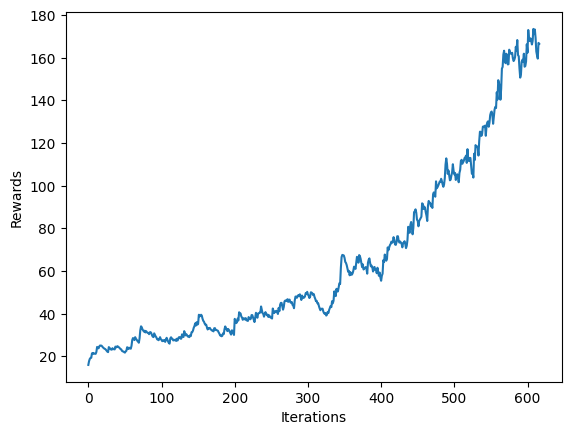

1/1 [==============================] - 40s 40s/step


In [ ]:
## Cartpole training! ##
## Note: stoping and restarting this cell will pick up training where you
#        left off. To restart training you need to rerun the cell above as
#        well (to re-initialize the model and optimizer)

if hasattr(tqdm, '_instances'): tqdm._instances.clear() # clear if it exists

#Changed from 500 to 100
for i_episode in range(1000):

    plotter.plot(smoothed_reward.get())
    # Restart the environment
    observation = env.reset()
    memory.clear()

    while True:
        # using our observation, choose an action and take it in the environment
        action = choose_action(cartpole_model, observation)
        next_observation, reward, done, info = env.step(action)
        # add to memory
        memory.add_to_memory(observation, action, reward)

        # is the episode over? did you crash or do so well that you're done?
        if done:
            # determine total reward and keep a record of this
            total_reward = sum(memory.rewards)
            smoothed_reward.append(total_reward)

            # initiate training - remember we don't know anything about how the
            #   agent is doing until it has crashed!
            g = train_step(cartpole_model, compute_loss, optimizer,
                       observations=np.vstack(memory.observations),
                       actions=np.array(memory.actions),
                       discounted_rewards = discount_rewards(memory.rewards))

            # reset the memory
            memory.clear()
            break
        # update our observatons
        observation = next_observation

## Save data to video

To get a sense of how our agent did, we can save a video of the trained model working on balancing the pole. Realize that this is a brand new environment that the agent has not seen before!

Let's display the saved video to watch how our agent did!


### Install virtual display and xvfb structure

In [ ]:
#Install virtual display and xvfb file structure.
!pip install pyvirtualdisplay
!apt update
!apt install xvfb

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Hit:3 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Hit:4 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:5 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:6 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:7 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Hit:8 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:9 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Get:10 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [634 kB]
Hit:11 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Get:12 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [1,036 kB]
Get:13 http://archive.ubuntu.com/ub

### `def save_video`

In [ ]:
def save_video_of_model(model, env_name, suffix=""):
    import skvideo.io
    from pyvirtualdisplay import Display
    display = Display(visible=0, size=(400, 300))
    display.start()

    env = gym.make(env_name)
    obs = env.reset()
    prev_obs = obs

    filename = env_name + suffix + ".mp4"
    output_video = skvideo.io.FFmpegWriter(filename)

    counter = 0
    done = False
    while not done:
        frame = env.render(mode='rgb_array')
        output_video.writeFrame(frame)

        if "CartPole" in env_name:
            input_obs = obs
        elif "Pong" in env_name:
            input_obs = pong_change(prev_obs, obs)
        else:
            raise ValueError(f"Unknown env for saving: {env_name}")

        action = model(np.expand_dims(input_obs, 0)).numpy().argmax()

        prev_obs = obs
        obs, reward, done, info = env.step(action)
        counter += 1

    output_video.close()
    print("Successfully saved {} frames into {}!".format(counter, filename))
    return filename

In [ ]:
matplotlib.use('Agg')
saved_cartpole = save_video_of_model(cartpole_model, "CartPole-v1")

#Manually save file to disk and watch

NameError: ignored

## TODO: Play video

### TODO : `def play_video`

In [ ]:
from pyvirtualdisplay import Display
display = Display(visible=0, size=(400, 300))
display.start()

In [ ]:
def play_video(filename, width=None):
    encoded = base64.b64encode(io.open(filename, 'r+b').read())
    video_width = 'width="' + str(width) + '"' if width is not None else ''
    embedded = HTML(data='''
        <video controls {0}>
            <source src="data:video/mp4;base64,{1}" type="video/mp4" />
        </video>'''.format(video_width, encoded.decode('ascii')))

    return embedded

How does the agent perform? Could you train it for shorter amounts of time and still perform well? Do you think that training longer would help even more?